# W207 - Forest Cover Type Prediction

# Forest Over Type Prediction

## Team:
- Brittney Van Hese
- Prabhaker Narsina
- Valérie Méausoone

In this final project, the team has been assigned the task of predicting the type of tree present in a 30mx30m patch of wilderness. Using online resources, we have supplemented the given feature and dataset knowledge to allow for expansion of relevant data columns; this research can be found in the Data Description section. 

## [Data Description](https://www.kaggle.com/c/forest-cover-type-prediction/data)

### Understanding our [tree cover types](https://csfs.colostate.edu/colorado-forests/forest-types/)


1 - [Spruce/Fir](https://csfs.colostate.edu/colorado-forests/forest-types/spruce-fir/): 
Very extensive in Colorado. Usually found at high elevations.   
Species is shade tolerant and tend to quickly repopulate shaded gaps in the forest.   
Very prone to fire, but it takes a very long time (300-400 years) for this type of tree to regenerate (unlike other types).   
Contribution to water supply.   

2 - [Lodgepole Pine](): 
Tolerates wide variety of soil and climate conditions, but does best in gentle slopes and well-drain, acidic, sandy, gravelling loams.    
Intolerant to shade.     
Develops post fire (seeds release under extreme heat).    

3 - [Ponderosa Pine](https://csfs.colostate.edu/colorado-trees/colorados-major-tree-species/):
1829 to 2743 meters (low elevation)    
Drough resistant and significant resource for water supply.   
At interface of wildlife and urban life.   


4 - [Cottonwood/Willow](https://csfs.colostate.edu/media/sites/22/2015/06/Cottonwood_Management_QuickGuide_26June2015.pdf)
Found at lower elevations.   
Eastern side    
Adjacent to rivers and streams.   
1066 - 1981 meters (low elevation)  
Susceptible to high-intensity fire (climate change). Does OK with low-intensity.   
Soil: sandy or silty.   

5 - [Aspen](https://csfs.colostate.edu/colorado-forests/forest-types/aspen/)
Loves sun and does well at higher temperatures.   
Open canopy allows light to reach forest floors.   
Grows well after fires.    
Dryer soils: sandy, gravelly slopes  

6 - [Douglas-fir](https://csfs.colostate.edu/colorado-trees/colorados-major-tree-species/#1466527937174-cd5c5e60-5efc) 
Shade-tolerant   
Rocky, moist soils  
Nothern slopes  
Elevation: 1829 - 2896 meters. 
Susceptible to fire when young, resistent when older.  

7 - [Krummholz](https://coloradobirdingtrail.com/birding-basics/habitats/subalpine-forest/)  
Stunted vegetation due to winds. 
Can only survived when sheltered by rock formations or snow covers  
Higher elevations, subalpine forests. 
Usually this habitat can be accessed in summer, because of snow covering during the rest of the year.  
Unlikely exposed to fire.  
Possibly thin soils.  

## Enviornment Setup

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier 
import xgboost as xgb
import time
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from sklearn.ensemble import StackingClassifier


#from google.colab import files
import io


%matplotlib inline

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Data Import & Definitions


This section stores all of the defined functions created for this project. These functions include: enineerged features, data preperation functions, and pipelines for testing and tuning models.

In [ ]:
#function to retrive the data, ingest it into the notebook, and perform basic preperations to the given data for a workable format.
def get_Orig_Data_for_ML_Models():
    #train_df = pd.read_csv(io.BytesIO(uploaded_train['train.csv']), index_col='Id')
    train_df = pd.read_csv('input/train.csv', index_col='Id')
    col_names = train_df.columns.tolist()

    print("Column names:")
    print(col_names)

    print("\nSample data:")
    train_df.head()

    # Isolate target data
    cover_type = train_df['Cover_Type']
    y = np.array(cover_type)

    # Dropping output from feature space
    to_drop = ['Cover_Type']
    cover_feat_space = train_df.drop(to_drop, axis = 1)

    # Pull out geatures for future use
    features = cover_feat_space.columns
    X_Orig = np.array(cover_feat_space).astype(np.float)

    #save the cover_types in useful names as the y_labels for easier visual references 
    y_labels=train_df['Cover_Type']
    y_labels_display = y_labels.replace({1:'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas Fir', 7: ' Krummholz'}, inplace=False)
    
    #save the cover_types as numerical outputs for easier performance references
    label_classes = [1,2,3,4,5,6,7]
    y_binarized = label_binarize(y, classes=[1,2,3,4,5,6,7])

    #set cross-validation K-folds to be used on all models 
    cross_validation = 5
    
    print("Feature space hold %d observations and %d features" % X_Orig.shape)
    print("Unique target labels:", np.unique(y))
    return (train_df, col_names, X_Orig, y, y_labels, y_labels_display, y_binarized, cross_validation)

In [ ]:
#Transform binary into a few categorical variables, and giving them more meaningful names where possible
def replace_with_cover_type_desc(data):
    
    data['Cover_Type'].replace({1:'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas Fir', 7: ' Krummholz'}, inplace=True)
    return (data)

In [ ]:
#Transform binary into a few categorical variables, and giving them more meaningful names where possible
def rename_wilderness_area(data):
    data = data.rename(columns={"Wilderness_Area1":"Rawah_WA","Wilderness_Area2":"Neota_WA",
    "Wilderness_Area3":"Comanche_Peak_WA","Wilderness_Area4":"Cache_la_Poudre_WA"})

    data['Wilderness_Areas'] = (data.iloc[:,10:14] == 1).idxmax(1)
    return (data)

### Feature Engineering Definitions

In [ ]:
#aggregate soil types into one categorical column
def add_soil_type(data):
    data['Soil_Type'] = (data[['Soil_Type1', 'Soil_Type2',
               'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
               'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']] == 1).idxmax(1)
    return (data)

In [ ]:
#from online research section, create function to add the soil family names to each soil type
def add_soil_family(data):
    data['Soil_Family'] = data['Soil_Type'].replace({'Soil_Type1':'Cathedral',
                                                            'Soil_Type2':'Vanet-Ratake',
                                                            'Soil_Type3':'Haploborolis',
                                                            'Soil_Type4':'Ratake',
                                                            'Soil_Type5':'Vanet',
                                                            'Soil_Type6':'Vanet-Wetmore ',
                                                            'Soil_Type7':'Gothic',
                                                            'Soil_Type8':'Supervisor-Limber',
                                                            'Soil_Type9':'Troutville',
                                                            'Soil_Type10':'Bullwark Catamount families',
                                                            'Soil_Type11':'Bullwark Catamount families',
                                                            'Soil_Type12':'Legault family',
                                                            'Soil_Type13':'Catamount Bullwark',
                                                            'Soil_Type14':'Pachic Argiborolis',
                                                            'Soil_Type15':'Soil_Type15',
                                                            'Soil_Type16':'Cryaquolis-Cryoborolis',
                                                            'Soil_Type17':'Gateview',
                                                            'Soil_Type18':'Rogert family',
                                                            'Soil_Type19':'Typic Cryaquolis-Borohemists',
                                                            'Soil_Type20':'Typic Cryaquepts-Typic Cryaquolls',
                                                            'Soil_Type21':'Leighcan family',
                                                            'Soil_Type22':'Leighcan family',
                                                            'Soil_Type23':'Leighcan family',
                                                            'Soil_Type24':'Leighcan family',
                                                            'Soil_Type25':'Leighcan family',
                                                            'Soil_Type26':'Catamount Granile ',
                                                            'Soil_Type27':'Leighcan family',
                                                            'Soil_Type28':'Leighcan family',
                                                            'Soil_Type29':'Como Legault',
                                                            'Soil_Type30':'Como Legault',
                                                            'Soil_Type31':'Leighcan Catamount',
                                                            'Soil_Type32':'Leighcan Catamount',
                                                            'Soil_Type33':'Leighcan Catamount',
                                                            'Soil_Type34':'Cryorthents',
                                                            'Soil_Type35':'Cryumbrepts Cryaquepts',
                                                            'Soil_Type36':'Bross ',
                                                            'Soil_Type37':'Cryumbrepts Cryorthents',
                                                            'Soil_Type38':'Leighcan Moran',
                                                            'Soil_Type39':'Leighcan Moran',
                                                            'Soil_Type40':'Moran'}                                                         
                                                            , inplace=False)
    return (data)

In [ ]:
#from online research section, create function to add the soil complex names to each soil type
def add_Soil_Complex(data):
    
    data['Soil_Complex'] = data['Soil_Type'].replace({'Soil_Type1':'Rock outcrop',
                                                    'Soil_Type2':'Unspecified',
                                                    'Soil_Type3':'Rock outcrop',
                                                    'Soil_Type4':'Rock outcrop',
                                                    'Soil_Type5':'Rock outcrop',
                                                    'Soil_Type6':'Rock outcrop',
                                                    'Soil_Type7':'Unspecified',
                                                    'Soil_Type8':'Unspecified',
                                                    'Soil_Type9':'Unspecified',
                                                    'Soil_Type10':'Rock outcrop',
                                                    'Soil_Type11':'Rock land',
                                                    'Soil_Type12':'Rock land',
                                                    'Soil_Type13':'Rock land',
                                                    'Soil_Type14':'Aquolis',
                                                    'Soil_Type15':'Unspecified',
                                                    'Soil_Type16':'Cryaquolis-Cryoborolis',
                                                    'Soil_Type17':'Cryaquolis',
                                                    'Soil_Type18':'Unspecified',
                                                    'Soil_Type19':'Typic Cryaquolis-Borohemists',
                                                    'Soil_Type20':'Typic Cryaquepts-Typic Cryaquolis',
                                                    'Soil_Type21':'Typic Cryaquolis till substratum',
                                                    'Soil_Type22':'Unspecified',
                                                    'Soil_Type23':'Typic Cryaquolis',
                                                    'Soil_Type24':'Unspecified',
                                                    'Soil_Type25':'Unspecified',
                                                    'Soil_Type26':'Unspecified',
                                                    'Soil_Type27':'Rock outcrop',
                                                    'Soil_Type28':'Rock outcrop',
                                                    'Soil_Type29':'Unspecified',
                                                    'Soil_Type30':'Rock land',
                                                    'Soil_Type31':'Unspecified',
                                                    'Soil_Type32':'Rock outcrop',
                                                    'Soil_Type33':'Rock outcrop',
                                                    'Soil_Type34':'Rock land',
                                                    'Soil_Type35':'Rock outcrop',
                                                    'Soil_Type36':'Cryumbrepts  Rock land',
                                                    'Soil_Type37':'Rock outcrop',
                                                    'Soil_Type38':'Cryaquolis',
                                                    'Soil_Type39':'Cryorthents',
                                                    'Soil_Type40':'Cryorthents Rock land '} , inplace=False)
    return (data)
                                                         

In [ ]:
#from online research section, create function to add the soil depth measurements to each soil type as a categorical representation of depth from [-2,2]
def add_Soil_depth(data):
    
    data['Soil_Depth'] = data['Soil_Type'].replace({'Soil_Type1':'0',
                                                    'Soil_Type2':'0',
                                                    'Soil_Type3':'-1',
                                                    'Soil_Type4':'0',
                                                    'Soil_Type5':'0',
                                                    'Soil_Type6':'0',
                                                    'Soil_Type7':'2',
                                                    'Soil_Type8':'1',
                                                    'Soil_Type9':'2',
                                                    'Soil_Type10':'1',
                                                    'Soil_Type11':'1',
                                                    'Soil_Type12':'0',
                                                    'Soil_Type13':'1',
                                                    'Soil_Type14':'-1',
                                                    'Soil_Type15':'-1',
                                                    'Soil_Type16':'-1',
                                                    'Soil_Type17':'2',
                                                    'Soil_Type18':'0',
                                                    'Soil_Type19':'-1',
                                                    'Soil_Type20':'-1',
                                                    'Soil_Type21':'2',
                                                    'Soil_Type22':'2',
                                                    'Soil_Type23':'2',
                                                    'Soil_Type24':'2',
                                                    'Soil_Type25':'2',
                                                    'Soil_Type26':'1',
                                                    'Soil_Type27':'2',
                                                    'Soil_Type28':'2',
                                                    'Soil_Type29':'1',
                                                    'Soil_Type30':'2',
                                                    'Soil_Type31':'2',
                                                    'Soil_Type32':'1',
                                                    'Soil_Type33':'1',
                                                    'Soil_Type34':'-1',
                                                    'Soil_Type35':'-1',
                                                    'Soil_Type36':'2',
                                                    'Soil_Type37':'-1',
                                                    'Soil_Type38':'2',
                                                    'Soil_Type39':'2',
                                                    'Soil_Type40':'2',} , inplace=False)
    return (data)

In [ ]:
#from online research section, create function to add a representation score of how stony the soil from [0,3]
def add_Soil_Stony(data):
    
    data['Soil_Stony'] = data['Soil_Type'].replace({'Soil_Type1':'3',
                                                    'Soil_Type2':'2',
                                                    'Soil_Type3':'0',
                                                    'Soil_Type4':'0',
                                                    'Soil_Type5':'0',
                                                    'Soil_Type6':'1',
                                                    'Soil_Type7':'0',
                                                    'Soil_Type8':'0',
                                                    'Soil_Type9':'2',
                                                    'Soil_Type10':'0',
                                                    'Soil_Type11':'0',
                                                    'Soil_Type12':'1',
                                                    'Soil_Type13':'0',
                                                    'Soil_Type14':'0',
                                                    'Soil_Type15':'0',
                                                    'Soil_Type16':'0',
                                                    'Soil_Type17':'0',
                                                    'Soil_Type18':'2',
                                                    'Soil_Type19':'0',
                                                    'Soil_Type20':'0',
                                                    'Soil_Type21':'0',
                                                    'Soil_Type22':'0',
                                                    'Soil_Type23':'0',
                                                    'Soil_Type24':'3',
                                                    'Soil_Type25':'3',
                                                    'Soil_Type26':'2',
                                                    'Soil_Type27':'3',
                                                    'Soil_Type28':'3',
                                                    'Soil_Type29':'3',
                                                    'Soil_Type30':'3',
                                                    'Soil_Type31':'3',
                                                    'Soil_Type32':'3',
                                                    'Soil_Type33':'3',
                                                    'Soil_Type34':'3',
                                                    'Soil_Type35':'0',
                                                    'Soil_Type36':'3',
                                                    'Soil_Type37':'3',
                                                    'Soil_Type38':'3',
                                                    'Soil_Type39':'3',
                                                    'Soil_Type40':'3'} , inplace=False)
    return (data)

In [ ]:
#from online research section, create function to add a binary representation score of how rubly the soil [0,1]
def add_Soil_Rubbly(data):
    
    data['Soil_Rubbly'] = data['Soil_Type'].replace({'Soil_Type1':'0',
                                                    'Soil_Type2':'0',
                                                    'Soil_Type3':'1',
                                                    'Soil_Type4':'1',
                                                    'Soil_Type5':'1',
                                                    'Soil_Type6':'0',
                                                    'Soil_Type7':'0',
                                                    'Soil_Type8':'0',
                                                    'Soil_Type9':'0',
                                                    'Soil_Type10':'1',
                                                    'Soil_Type11':'1',
                                                    'Soil_Type12':'0',
                                                    'Soil_Type13':'1',
                                                    'Soil_Type14':'0',
                                                    'Soil_Type15':'0',
                                                    'Soil_Type16':'0',
                                                    'Soil_Type17':'0',
                                                    'Soil_Type18':'0',
                                                    'Soil_Type19':'0',
                                                    'Soil_Type20':'0',
                                                    'Soil_Type21':'0',
                                                    'Soil_Type22':'0',
                                                    'Soil_Type23':'0',
                                                    'Soil_Type24':'0',
                                                    'Soil_Type25':'0',
                                                    'Soil_Type26':'0',
                                                    'Soil_Type27':'0',
                                                    'Soil_Type28':'0',
                                                    'Soil_Type29':'0',
                                                    'Soil_Type30':'0',
                                                    'Soil_Type31':'0',
                                                    'Soil_Type32':'0',
                                                    'Soil_Type33':'0',
                                                    'Soil_Type34':'0',
                                                    'Soil_Type35':'0',
                                                    'Soil_Type36':'0',
                                                    'Soil_Type37':'0',
                                                    'Soil_Type38':'0',
                                                    'Soil_Type39':'0',
                                                    'Soil_Type40':'0'} , inplace=False)
    return (data)


In [ ]:
#from online research section, create function to add a binary representation score of how bouldery the soil [0,1]
def add_Soil_Bouldery(data):
    
    data['Soil_Bouldery'] = data['Soil_Type'].replace({'Soil_Type1':'0',
                                                        'Soil_Type2':'0',
                                                        'Soil_Type3':'0',
                                                        'Soil_Type4':'0',
                                                        'Soil_Type5':'0',
                                                        'Soil_Type6':'0',
                                                        'Soil_Type7':'0',
                                                        'Soil_Type8':'0',
                                                        'Soil_Type9':'0',
                                                        'Soil_Type10':'0',
                                                        'Soil_Type11':'0',
                                                        'Soil_Type12':'0',
                                                        'Soil_Type13':'0',
                                                        'Soil_Type14':'0',
                                                        'Soil_Type15':'0',
                                                        'Soil_Type16':'0',
                                                        'Soil_Type17':'0',
                                                        'Soil_Type18':'0',
                                                        'Soil_Type19':'0',
                                                        'Soil_Type20':'0',
                                                        'Soil_Type21':'0',
                                                        'Soil_Type22':'1',
                                                        'Soil_Type23':'0',
                                                        'Soil_Type24':'0',
                                                        'Soil_Type25':'0',
                                                        'Soil_Type26':'0',
                                                        'Soil_Type27':'0',
                                                        'Soil_Type28':'0',
                                                        'Soil_Type29':'0',
                                                        'Soil_Type30':'0',
                                                        'Soil_Type31':'0',
                                                        'Soil_Type32':'0',
                                                        'Soil_Type33':'0',
                                                        'Soil_Type34':'0',
                                                        'Soil_Type35':'0',
                                                        'Soil_Type36':'0',
                                                        'Soil_Type37':'0',
                                                        'Soil_Type38':'0',
                                                        'Soil_Type39':'0',
                                                        'Soil_Type40':'0'} , inplace=False)
    return (data)

In [ ]:
#from online research section, create function to add a binary representation score of if the soil tends to freeze [0,1]
def add_Soil_Freezing(data):
    
    data['Soil_Freezing'] = data['Soil_Type'].replace({'Soil_Type1':'0',
                                                        'Soil_Type2':'0',
                                                        'Soil_Type3':'0',
                                                        'Soil_Type4':'0',
                                                        'Soil_Type5':'0',
                                                        'Soil_Type6':'0',
                                                        'Soil_Type7':'0',
                                                        'Soil_Type8':'0',
                                                        'Soil_Type9':'0',
                                                        'Soil_Type10':'0',
                                                        'Soil_Type11':'0',
                                                        'Soil_Type12':'0',
                                                        'Soil_Type13':'0',
                                                        'Soil_Type14':'0',
                                                        'Soil_Type15':'0',
                                                        'Soil_Type16':'1',
                                                        'Soil_Type17':'1',
                                                        'Soil_Type18':'0',
                                                        'Soil_Type19':'1',
                                                        'Soil_Type20':'1',
                                                        'Soil_Type21':'1',
                                                        'Soil_Type22':'0',
                                                        'Soil_Type23':'1',
                                                        'Soil_Type24':'0',
                                                        'Soil_Type25':'0',
                                                        'Soil_Type26':'0',
                                                        'Soil_Type27':'0',
                                                        'Soil_Type28':'0',
                                                        'Soil_Type29':'0',
                                                        'Soil_Type30':'0',
                                                        'Soil_Type31':'0',
                                                        'Soil_Type32':'0',
                                                        'Soil_Type33':'0',
                                                        'Soil_Type34':'0',
                                                        'Soil_Type35':'0',
                                                        'Soil_Type36':'1',
                                                        'Soil_Type37':'0',
                                                        'Soil_Type38':'1',
                                                        'Soil_Type39':'1',
                                                        'Soil_Type40':'1'} , inplace=False)
    return(data)

In [ ]:
#from online research section, create function to add a score representation of how well the soil drains from [-1,3]
def add_Soil_Drainage (data):
    
    data['Soil_Drainage'] = data['Soil_Type'].replace({'Soil_Type1':'3',
                                                    'Soil_Type2':'2',
                                                    'Soil_Type3':'-1',
                                                    'Soil_Type4':'2',
                                                    'Soil_Type5':'2',
                                                    'Soil_Type6':'2',
                                                    'Soil_Type7':'2',
                                                    'Soil_Type8':'2',
                                                    'Soil_Type9':'2',
                                                    'Soil_Type10':'3',
                                                    'Soil_Type11':'3',
                                                    'Soil_Type12':'3',
                                                    'Soil_Type13':'3',
                                                    'Soil_Type14':'-1',
                                                    'Soil_Type15':'-1',
                                                    'Soil_Type16':'-1',
                                                    'Soil_Type17':'3',
                                                    'Soil_Type18':'2',
                                                    'Soil_Type19':'-1',
                                                    'Soil_Type20':'-1',
                                                    'Soil_Type21':'3',
                                                    'Soil_Type22':'2',
                                                    'Soil_Type23':'2',
                                                    'Soil_Type24':'2',
                                                    'Soil_Type25':'2',
                                                    'Soil_Type26':'2',
                                                    'Soil_Type27':'2',
                                                    'Soil_Type28':'2',
                                                    'Soil_Type29':'3',
                                                    'Soil_Type30':'3',
                                                    'Soil_Type31':'2',
                                                    'Soil_Type32':'3',
                                                    'Soil_Type33':'3',
                                                    'Soil_Type34':'-1',
                                                    'Soil_Type35':'-1',
                                                    'Soil_Type36':'2',
                                                    'Soil_Type37':'-1',
                                                    'Soil_Type38':'2',
                                                    'Soil_Type39':'2',
                                                    'Soil_Type40':'2'} , inplace=False)
    return (data)

In [ ]:
#from online research section, create function to add a the annual temperature range of the soil in each area
def add_Soil_Annual_Temp_Range (data):
    
    data['Soil_Annual_Temp_Range'] = data['Soil_Type'].replace({'Soil_Type1':40,
                                                                'Soil_Type2':40,
                                                                'Soil_Type3':-1,
                                                                'Soil_Type4':40,
                                                                'Soil_Type5':40,
                                                                'Soil_Type6':40,
                                                                'Soil_Type7':30,
                                                                'Soil_Type8':40,
                                                                'Soil_Type9':30,
                                                                'Soil_Type10':40,
                                                                'Soil_Type11':40,
                                                                'Soil_Type12':40,
                                                                'Soil_Type13':40,
                                                                'Soil_Type14':-1,
                                                                'Soil_Type15':-1,
                                                                'Soil_Type16':-1,
                                                                'Soil_Type17':30,
                                                                'Soil_Type18':30,
                                                                'Soil_Type19':-1,
                                                                'Soil_Type20':-1,
                                                                'Soil_Type21':30,
                                                                'Soil_Type22':30,
                                                                'Soil_Type23':30,
                                                                'Soil_Type24':30,
                                                                'Soil_Type25':30,
                                                                'Soil_Type26':30,
                                                                'Soil_Type27':30,
                                                                'Soil_Type28':30,
                                                                'Soil_Type29':30,
                                                                'Soil_Type30':30,
                                                                'Soil_Type31':30,
                                                                'Soil_Type32':30,
                                                                'Soil_Type33':30,
                                                                'Soil_Type34':-1,
                                                                'Soil_Type35':-1,
                                                                'Soil_Type36':20,
                                                                'Soil_Type37':-1,
                                                                'Soil_Type38':30,
                                                                'Soil_Type39':30,
                                                                'Soil_Type40':30} , inplace=False)
    return(data)

In [ ]:
#add a variable to represent the amount of shade recieved as a binary instead of [0,255]
def light_binary(row):
    if (row['Hillshade_9am'] >150) &  (row['Hillshade_Noon'] >150) & (row['Hillshade_3pm'] >150):
        return 1
    return 0

In [ ]:
def add_light(data):
    data['Light'] = data.apply(lambda row: light_binary(row), axis=1)
    return (data)

### Modeling and Performance Evaluation Pipeline Defintions

In [ ]:
def display_CrossValidation_class_level_charts(y_true, y_predict, label_classes):
# ################################################################################
# This function is implemented to display each class level Cross Validation chart
# y_true: Truth data given for lable
# y_predict:  Predicted labels from Machine learning models
# label_Classes: All the labels_class we are trying to predict
# #################################################################################
    fig = plt.figure(figsize=(14,12))
    plt.tight_layout()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 2

    for i in range(len(label_classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        sp = fig.add_subplot(3, 3, i+1)
        sp.set_title('cover_class ' + str( label_classes[i]))
        plt.plot(fpr[i], tpr[i], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    plt.show() 

def ml_pipleline(ml_name, model, X,y, binarize = False,    detailedCVcharts = False):

    label_classes=[1,2,3,4,5,6,7]
    y_binarized = label_binarize(y,classes=[1,2,3,4,5,6,7])
    
    X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.3, random_state=17)
    
    ml_pipe = Pipeline([('scaler', StandardScaler()), 
                           (ml_name, model)]) 

    ml_pipe.fit(X_train, y_train)

#     y_train_predict = ml_pipe.predict(X_train)
#     train_report = classification_report(y_train, y_train_predict)
#     print('Training Set - Classication report metrics: \n ', train_report)
    
    
    y_predict = ml_pipe.predict(X_valid)
    report = classification_report( y_valid, y_predict)

#    print(color.BOLD, ml_name, color.END, '\n')
#     print('Validation Set - Classication report metrics: \n ', report)

    cv_scores = cross_val_score(model, X, y, cv=cross_validation)
    
#     print('Cross Validation Scores:', cv_scores)
    print('\n Cross Validation Average Score', round(np.mean(cv_scores),3))
    

    if detailedCVcharts:
        display_CrossValidation_class_level_charts(y_valid, y_predict,label_classes)
        
    return(report, y_predict, y_valid)


def display_confusion_matrix(y_valid, y_predict):
    print(color.BOLD + "Confusion Matrix" + color.END + "\n")
    mat = confusion_matrix(y_valid, y_predict)
    plt.figure(figsize=(10,10))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=np.unique(y_labels_display),
                yticklabels=np.unique(y_labels_display))
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.show()

def get_ML_data_after_feature_engineering(data):

    # Dropping output from feature space
    to_drop = ['Cover_Type']
    cover_feat_space = data.drop(to_drop, axis = 1)

    # Pull out geatures for future use
    features = cover_feat_space.columns
    X_feature_engineered = np.array(cover_feat_space).astype(np.float)
    return(X_feature_engineered)
  

In [ ]:
def feature_select_Data_for_Model(data, binarize = False):
    # Isolate target data
    cover_type = data['Cover_Type']
    y = np.array(cover_type)

    # Dropping output from feature space
    # to_drop = ['Cover_Type']
    to_drop = ['Cover_Type','Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8',
              'Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17',
              'Soil_Type18','Soil_Type19','Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26',
              'Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type26',
              'Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39', 'Soil_Type40']



    cover_feat_space = data.drop(to_drop, axis = 1)

    # Pull out geatures for future use
    features_selected = cover_feat_space.columns
    X = np.array(cover_feat_space).astype(np.float)


    if binarize:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y_binarized, test_size=0.3, random_state=17)
    else:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.3, random_state=17)

    scaler = StandardScaler()
    scalar = scaler.fit(X_train)
    X_std_train = scaler.transform(X_train)
    X_std_valid =  scaler.transform(X_valid)   
    
    return(cover_feat_space,features_selected,X_std_train, X_std_valid, y_train, y_valid)

In [ ]:
train_df, col_names, X_Orig, y, y_labels, y_labels_display, y_binarized, cross_validation = get_Orig_Data_for_ML_Models()

Column names:
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

Sample data:
Feature space hold 15120 observations and 54 features
Uniqu

In [ ]:
# Assessing missingness
print("There are", np.count_nonzero(np.isnan(X_Orig)), "missing values among our features")
print("There are", np.count_nonzero(np.isnan(y)), "missing values among our target values")

#Assessing plausibility of values
print("\nLooking at summary statistics for our training data:")
train_df.describe()

There are 0 missing values among our features
There are 0 missing values among our target values

Looking at summary statistics for our training data:


Elevation        Aspect  ...   Soil_Type40    Cover_Type
count  15120.000000  15120.000000  ...  15120.000000  15120.000000
mean    2749.322553    156.676653  ...      0.030357      4.000000
std      417.678187    110.085801  ...      0.171574      2.000066
min     1863.000000      0.000000  ...      0.000000      1.000000
25%     2376.000000     65.000000  ...      0.000000      2.000000
50%     2752.000000    126.000000  ...      0.000000      4.000000
75%     3104.000000    261.000000  ...      0.000000      6.000000
max     3849.000000    360.000000  ...      1.000000      7.000000

[8 rows x 55 columns]

In [ ]:
train_df = replace_with_cover_type_desc(train_df)

## Exploratory Data Analysis

### Feature Exploration

First, we ensure that each target class is represented fairly in the data set. 

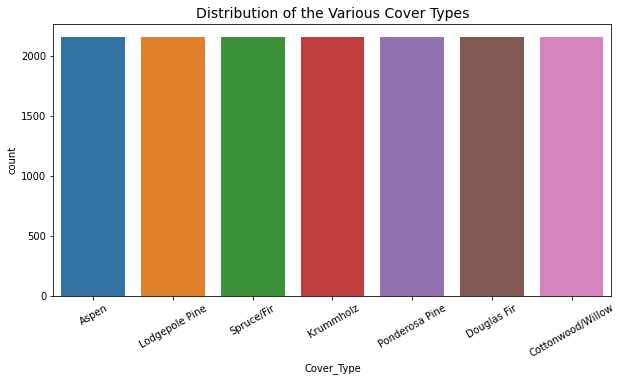

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Distribution of the Various Cover Types", size = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax = sns.countplot(x = "Cover_Type", data = train_df)

From the figure above, it is clear that each target class is equally represented in the data set. Next, we see if any of the features offer distinctions between our Cover Types; starting with our categorical features. 

### Categorical Variables

In [ ]:
#Plotting given catgorical features: Wilderness Areas

train_df = rename_wilderness_area(train_df)

fig = px.histogram(train_df, x="Wilderness_Areas", color="Cover_Type", barmode="group", title='Distribution of Wildreness Area by Cover Type')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
#Plotting given catgorical features: Soil Type

add_soil_type(train_df)
fig = px.histogram(train_df, x="Soil_Type", color="Cover_Type", title='Distribution of the Soil Types by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

Each of our categorical feature values appear to provide separation between our target classes. Next let us look at the distributions of our numerical features.

### Continuous Variables

<Figure size 1152x576 with 0 Axes>

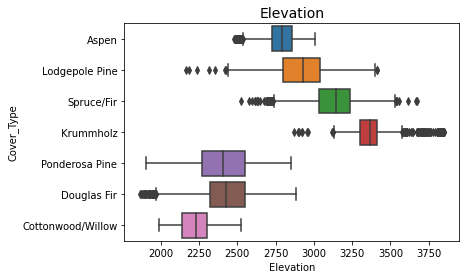

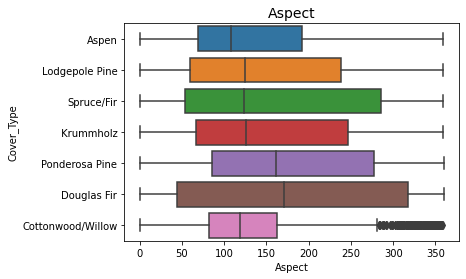

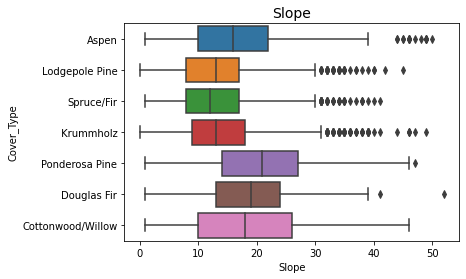

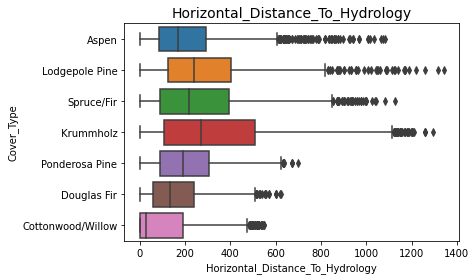

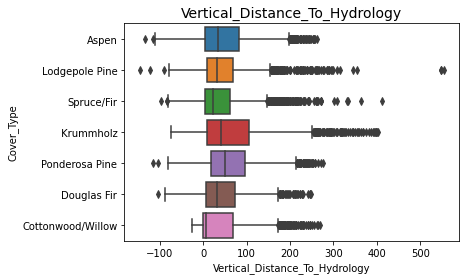

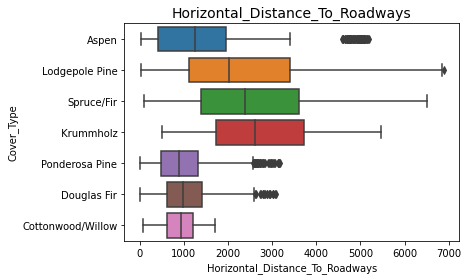

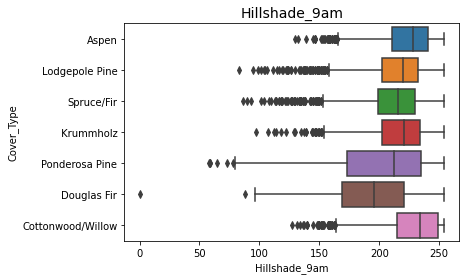

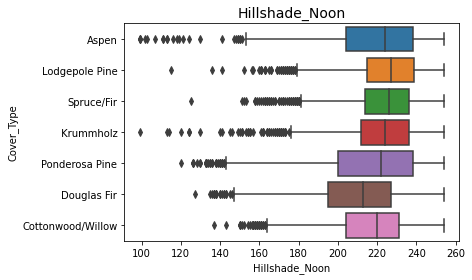

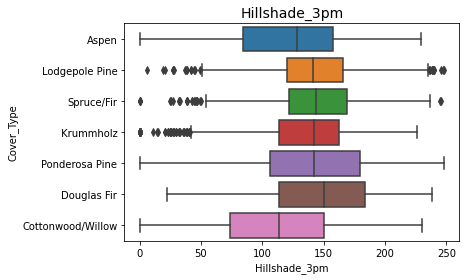

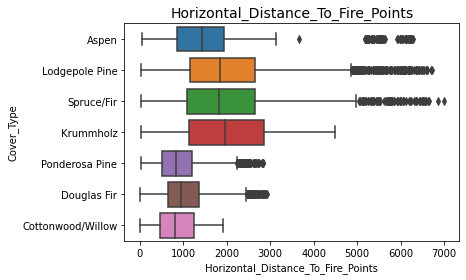

In [ ]:
#Plotting and grouping numerical features according to target classes
plt.figure(figsize=(16, 8))

num_values_range = 10
# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(num_values_range):
    fig1, ax1 = plt.subplots()
    ax1.set_title(train_df.columns[feature], size = 14)
    ax1 = sns.boxplot(x = train_df.columns[feature], y = 'Cover_Type' , data = train_df)

From all the above plots, we do see some separation between features and classes, but we also see significant overlap of the numerical feature distributions. This could cause problems for our predictions depending on the model we select.  
Elevation does appear to show most differentiation between the cover types

In [ ]:
fig = px.histogram(train_df, x="Elevation", color="Cover_Type", title= "Distribution of Cover Types")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

Wilderness also appears to be a differentiating feature and seems linked to other continuous variables

In [ ]:
fig = px.histogram(train_df, x="Elevation", color="Wilderness_Areas", title='Distribution of Wilderness Areas by Elevation')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
fig = px.histogram(train_df, x="Slope", color="Wilderness_Areas", title='Distribution of Wilderness Areas by Slope')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
fig = px.histogram(train_df, x="Aspect", color="Wilderness_Areas", title='Distribution of Wilderness Areas by Aspect')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

The last feature evaluation step we will take is an look at feature covariance. 

In [ ]:
label_classes = [1, 2, 3,4,5,6,7]
y_binarized = label_binarize(y, classes = label_classes)
outcome_df = pd.DataFrame(y_binarized, columns = ['Spruce_Fir','Lodgepole_Pine','Ponderosa Pine','Cottonwood_Willow', 'Aspen','Douglas Fir','Krummholz'])
corr_data = pd.concat([train_df.iloc[:,0:54], outcome_df], axis=1, sort=False)

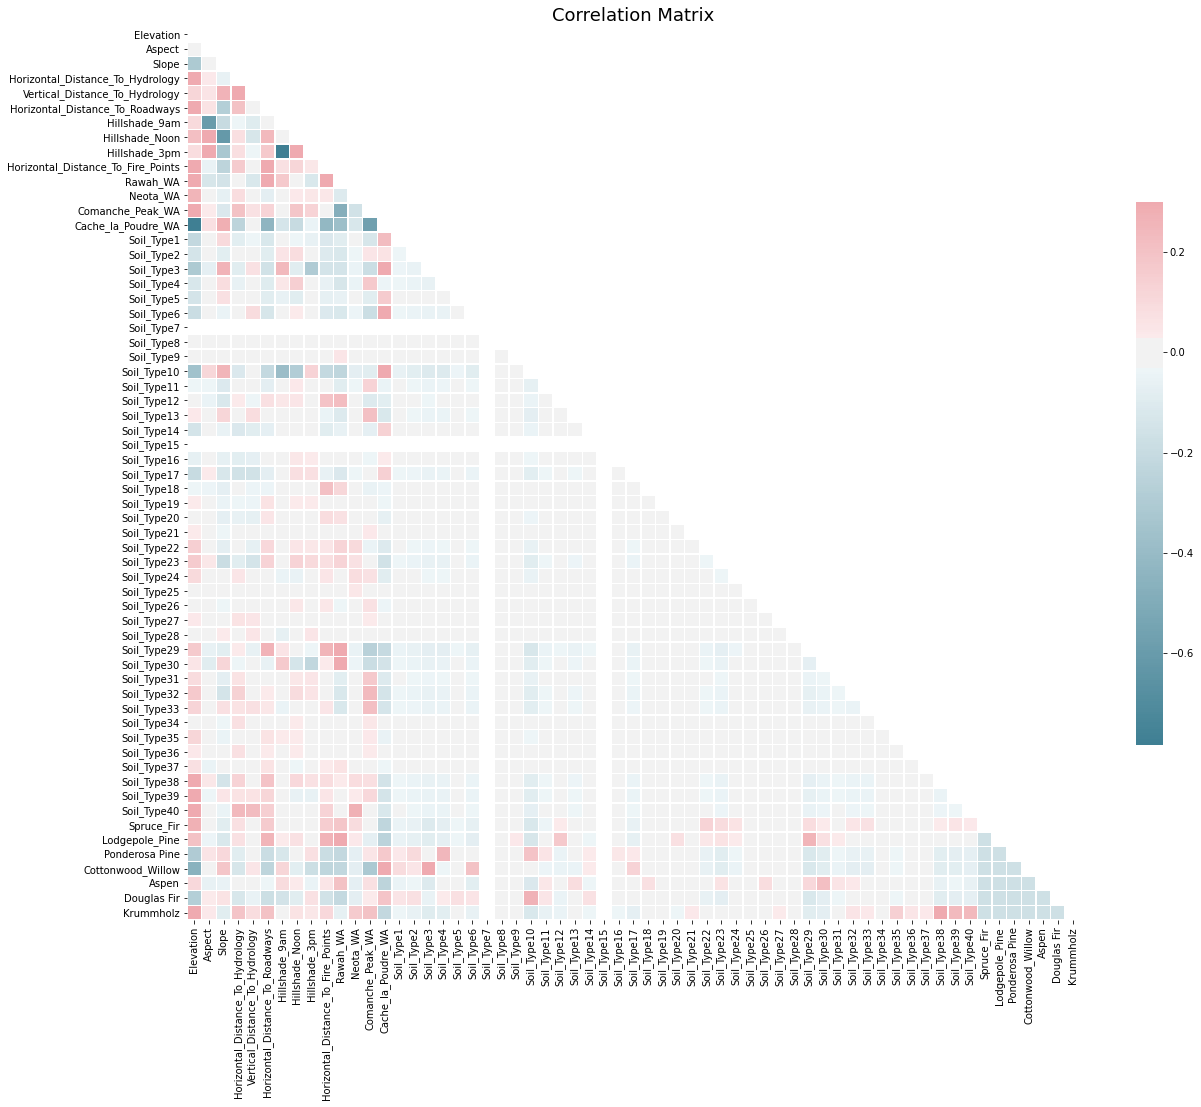

In [ ]:
# Compute the correlation matrix 
#corr_data = train_df.copy()
corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax.set_title("Correlation Matrix", size = 18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Engineering

From the online research conducted and from the inital EDA showing a lack of clear distinguishing features for each cover type class, we believe that the addition of engineered features will improve our models performance and abilities to differeniate between Cover Types.

The first feature we look to expand based on our gained knowledge is the Soil types given in the data set. We have gathered lots of information about the characteristics of the different soil types and add them here. 

Then we look to features like Hill side Shade and our given distance metrics to evalaute any other possible features we can extract. 

###  [Soils](https://soilseries.sc.egov.usda.gov/osdname.aspx)

Soil is made of sand, silt, clay and organic matter.  

When looking more closely at the description of soil types, we find common elements that can could extracted as additional features. To improve contextual understanding on which soils these forests grow, we extract:
- soil family
- soil complex
- soil rock types (stony, rubbly, bouldery). 
- soil depth
- soil drainage
- whether these soils freeze (indicated by the term "cryo/crya" in the soil type descriptions)
- annual average temperatures (derived from soil family, whose description was provided here: https://soilseries.sc.egov.usda.gov/osdname.aspx)

When nuanced information was provided on intensity of these measures (i.e.: how deep, how much water is drained) Missing values were assigned a number of "-1".    
More information is available here: 
https://docs.google.com/spreadsheets/d/1NrDtevQPmZxGge1wOPoCqd7EwuflO4MU4FkZqzPOJJ8/edit?usp=sharing

Now we add each of these feature to our data set and plot them in reference to our Cover Type variable to see if we can gain insight into distinguishing features between tree types in the forest. 

In [ ]:
train_df = add_soil_family(train_df)

In [ ]:
fig = px.histogram(train_df, x="Soil_Family", color="Cover_Type", title='Distribution of the Soil Families by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
train_df = add_Soil_Complex(train_df)

In [ ]:
fig = px.histogram(train_df, x="Soil_Complex", color="Cover_Type", title='Distribution of the Soil Complexes by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
train_df = add_Soil_depth(train_df)

In [ ]:
fig = px.histogram(train_df, x="Soil_Depth", color="Cover_Type", title='Distribution of the Soil Depths by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
train_df = add_Soil_Stony(train_df)

In [ ]:
fig = px.histogram(train_df, x="Soil_Stony", color="Cover_Type", title='Distribution of the Soil Stone Types by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
train_df = add_Soil_Rubbly(train_df)

In [ ]:
fig = px.histogram(train_df, x="Soil_Rubbly", color="Cover_Type", title='Distribution of the Soil Rubble Types by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
train_df = add_Soil_Bouldery(train_df)

In [ ]:
fig = px.histogram(train_df, x="Soil_Bouldery", color="Cover_Type", title='Distribution of the Soil Boulder Types by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
train_df = add_Soil_Freezing(train_df)

In [ ]:
fig = px.histogram(train_df, x="Soil_Freezing", color="Cover_Type", title='Distribution of the Soil Freeze Types by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
train_df = add_Soil_Drainage(train_df)

In [ ]:
fig = px.histogram(train_df, x="Soil_Drainage", color="Cover_Type", title='Distribution of the Soil Drain Types by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
train_df = add_Soil_Annual_Temp_Range(train_df)

In [ ]:
fig = px.histogram(train_df, x="Soil_Annual_Temp_Range", color="Cover_Type", title='Distribution of the Soil Annual Temperature Range by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

#### Quality assessment of new soil features
#### Elevation and Soil features. 

We can test our assumptions on these new features by comparing them with what we know about elevation. For example, we can test whether soil complexes that have the term "cryo/crya" tend to be at higher elevtations. 

In [ ]:
df = px.data.tips()
fig = px.box(train_df, x="Soil_Complex", y="Elevation")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
df = px.data.tips()
fig = px.box(train_df, x="Soil_Annual_Temp_Range", y="Elevation")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

Similary, for forests that grow at higher elevations, we expect more bouldery, stony soils. 

In [ ]:
df = px.data.tips()
fig = px.box(train_df, x="Soil_Stony", y="Elevation")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
df = px.data.tips()
fig = px.box(train_df, x="Soil_Rubbly", y="Elevation")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

In [ ]:
df = px.data.tips()
fig = px.box(train_df, x="Soil_Bouldery", y="Elevation")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

### Hillshade

Based on our forest cover type descritions aove, we speculate that some types of trees are susceptible to grow with a lot of light (i.e.: lodgepole pine). 

In [ ]:
train_df = add_light(train_df)

In [ ]:
train_df['Light'].value_counts()

0    9996
1    5124
Name: Light, dtype: int64

In [ ]:
fig = px.histogram(train_df, x="Light", color="Cover_Type", title='Distribution of the Soil Drain Types by Cover Types')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

This feature does not show a lot of differentiation, but the amount of light at 9am, 12pm and 3pm during the summer solstice may be more homogeneous.  

### Distance Features

There are several additional features to extract from distance measures:
- Vertical and horizontal distance to hydrology can be combined to generate the Euclidean distance
- Horizontal distances to key points such as Fire and Hydrology can be combined (added or substracted) to measure how far appeart they are from each other, with respect to a tree cover area. 
- Simiarly, vertical distances, such as distance to hydrology and elevation can be combiend (added or substracted) to identify the relative distance of between a cover area and hydrology. 

In [ ]:
#use of mathematical transformations to enhance the distance features from the given data set
def add_more_features(data):   
    data['Ele_minus_VDtHyd'] = data.Elevation-data.Vertical_Distance_To_Hydrology
    data['Ele_plus_VDtHyd'] = data.Elevation+data.Vertical_Distance_To_Hydrology
    data['Distance_to_Hydrology'] = (data['Horizontal_Distance_To_Hydrology']**2+data['Vertical_Distance_To_Hydrology']**2)**0.5
    data['Hydro_plus_Fire'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Fire_Points']
    data['Hydro_minus_Fire'] = data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Fire_Points']
    data['Hydro_plus_Road'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Roadways']
    data['Hydro_minus_Road'] = data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Roadways']
    data['Fire_plus_Road'] = data['Horizontal_Distance_To_Fire_Points']+data['Horizontal_Distance_To_Roadways']
    data['Fire_minus_Road'] = data['Horizontal_Distance_To_Fire_Points']-data['Horizontal_Distance_To_Roadways']
    data['Soil_Type_agg'] = (data.iloc[:,15:55] == 1).idxmax(1).str.extract('(\D+)(\d+)', expand=False)[1]
    return (data)

In [ ]:
train_df = add_more_features(train_df)

In [ ]:
train_df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Rawah_WA', 'Neota_WA',
       'Comanche_Peak_WA', 'Cache_la_Poudre_WA', 'Soil_Type1', 'Soil_Type2',
       'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
       'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type

## Enhanced Dataset

With the conclusion of our feature engineering, we now look to prepare the new dataset with enchanced features to begin testing within new models.

In [ ]:
def prepare_for_ML_Program(data, test=False):

    if test:
        data_new = data[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
               'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
               'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
               'Horizontal_Distance_To_Fire_Points', 'Rawah_WA', 'Neota_WA',
               'Comanche_Peak_WA', 'Cache_la_Poudre_WA',
               'Soil_Depth', 'Soil_Stony', 'Soil_Rubbly', 'Soil_Bouldery',
               'Soil_Freezing','Soil_Drainage', 'Soil_Annual_Temp_Range',
               'Light', 'Ele_minus_VDtHyd', 'Ele_plus_VDtHyd',
               'Distance_to_Hydrology', 'Hydro_plus_Fire', 'Hydro_minus_Fire',
               'Hydro_plus_Road', 'Hydro_minus_Road', 'Fire_plus_Road',
               'Fire_minus_Road', 'Soil_Type1', 'Soil_Type2',
               'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
               'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']]
    
    else:
        data_new = data[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
               'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
               'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
               'Horizontal_Distance_To_Fire_Points', 'Rawah_WA', 'Neota_WA',
               'Comanche_Peak_WA', 'Cache_la_Poudre_WA',
               'Soil_Depth', 'Soil_Stony', 'Soil_Rubbly', 'Soil_Bouldery',
               'Soil_Freezing','Soil_Drainage', 'Soil_Annual_Temp_Range',
               'Light', 'Ele_minus_VDtHyd', 'Ele_plus_VDtHyd',
               'Distance_to_Hydrology', 'Hydro_plus_Fire', 'Hydro_minus_Fire',
               'Hydro_plus_Road', 'Hydro_minus_Road', 'Fire_plus_Road',
               'Fire_minus_Road', 'Soil_Type1', 'Soil_Type2',
               'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
               'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40','Cover_Type']]
        
        
    dummy = pd.get_dummies(data['Soil_Family'])
    data_new = pd.concat([data_new, dummy], axis =1)
    dummy = pd.get_dummies(data['Soil_Complex'])
    data_new = pd.concat([data_new, dummy], axis =1)
    return(data_new)

In [ ]:
train_new = prepare_for_ML_Program(train_df)

In [ ]:
list(train_new.columns)

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Rawah_WA',
 'Neota_WA',
 'Comanche_Peak_WA',
 'Cache_la_Poudre_WA',
 'Soil_Depth',
 'Soil_Stony',
 'Soil_Rubbly',
 'Soil_Bouldery',
 'Soil_Freezing',
 'Soil_Drainage',
 'Soil_Annual_Temp_Range',
 'Light',
 'Ele_minus_VDtHyd',
 'Ele_plus_VDtHyd',
 'Distance_to_Hydrology',
 'Hydro_plus_Fire',
 'Hydro_minus_Fire',
 'Hydro_plus_Road',
 'Hydro_minus_Road',
 'Fire_plus_Road',
 'Fire_minus_Road',
 'Soil_Type1',
 'Soil_Type2',
 'Soil_Type3',
 'Soil_Type4',
 'Soil_Type5',
 'Soil_Type6',
 'Soil_Type7',
 'Soil_Type8',
 'Soil_Type9',
 'Soil_Type10',
 'Soil_Type11',
 'Soil_Type12',
 'Soil_Type13',
 'Soil_Type14',
 'Soil_Type15',
 'Soil_Type16',
 'Soil_Type17',
 'Soil_Type18',
 'Soil_Type19',
 'Soil_Type20',
 'Soil_Type21',
 'Soil_Type22',
 'Soil_Type23',
 'Soil_Ty

In [ ]:
X_feature_engineered = get_ML_data_after_feature_engineering(train_new)

## Baseline Model

The model we have selected to start with as our baseline is K-Nearest Neighbors. The KNN was selected as a starting model, not only because it is computationally the simplest model to start from, but also our features represent geographical position and therefore, agriculturally, it makes sense that a tree would be the same species as their physically nearby neighbor.
We tested different number of neighbors and tested weighting our features. Below, we are displaying the model with best accuracy. 


 Cross Validation Average Score 0.753
Confusion Matrix



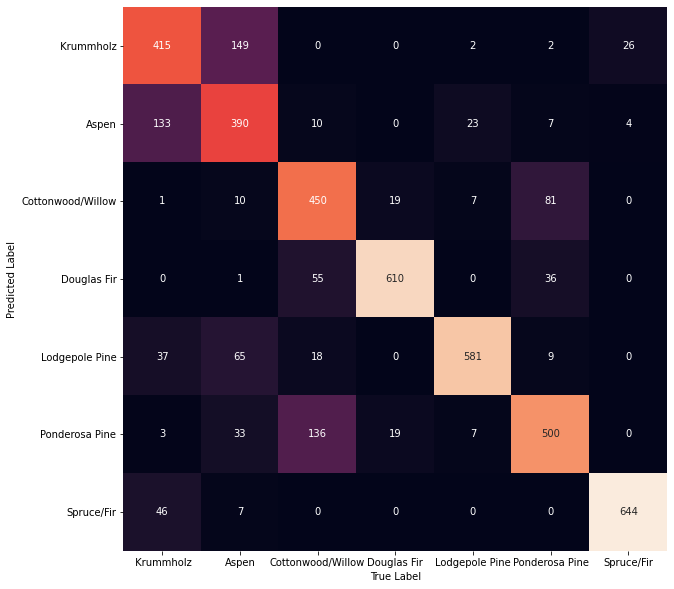

In [ ]:
# KNN Neighborhood with weights = uniform
#knn_values = [1,3,5,7,9]
knn_values = [1]
for value in knn_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=value)
    report, y_predict , y_valid= ml_pipleline('KNN with '+ str(value) +'  Neighbors', knn_classifier, \
                                      X_Orig, y, binarize = False, detailedCVcharts = False )
display_confusion_matrix (y_valid, y_predict)

Our confusion matrix indicates that, in all kNN models shown above, Kurmmholz and Aspen forest types get most often confused. In addition, it indicates that the accuracy of predictions is slightly inbalanced (Cottonwood gets most often mispredicted as Ponderosa Pine, but Ponderosa Pine does not get mispredicted as often for Cottonwood). Based on our readings, this may indicate that a distance measure may not be the most appropriate metric for our prediction model.   
Without further context for this problem, we define our main evaluation metric to be **accuracy**. 

### Enhanced Baseline Model

The first test of our additional features is in testing our Baseline model under the new feature space. We use the same configuration as our first Baseline model for direct comparison of performance.



 Cross Validation Average Score 0.725
Confusion Matrix



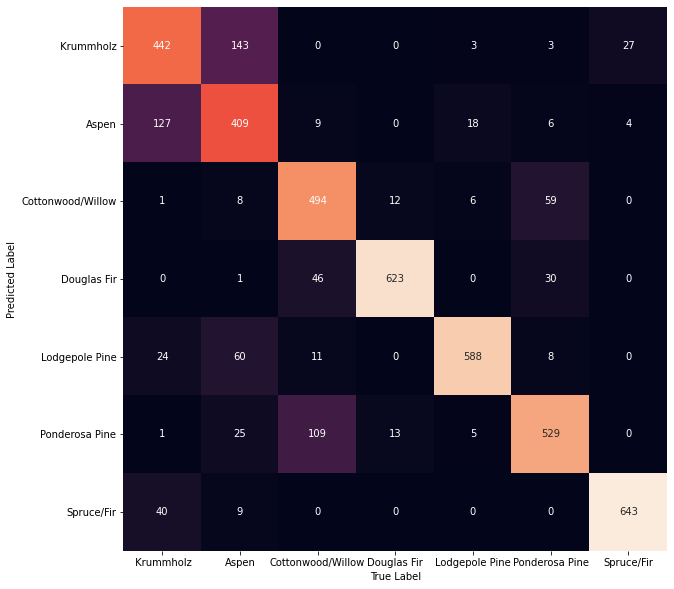

In [ ]:
# KNN Neighborhood with weights = uniform
#knn_values = [1,3,5,7,9]
knn_values = [1]
for value in knn_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=value)
    report, y_predict , y_valid= ml_pipleline('KNN with '+ str(value) +'  Neighbors - Enhanced', knn_classifier, \
                                      X_feature_engineered, y, binarize = False, detailedCVcharts = False )
display_confusion_matrix (y_valid, y_predict)

Our enhanced dataset did not improve performance for kNN. 

*Note: While we are only displaying below our models with highest accuracies, we have in fact tested others that did not result in great performance https://docs.google.com/spreadsheets/d/1eWCVlobr35lv0JADglACRm77WFw1kGes8KG4DUChTTA/edit#gid=0*

## Random Forest

Continuing our exploration of non-linear models, we next move a random forest which we believe will be better able to handle to overlapping features in its decision and ensemble (aggregated bootstrap / bagging) methods.

Implemented GridSearch to find the model with most optimized parameters. (commented out GridSearch once best parameters are found to perserve notebook runtime). 

In [ ]:
#rf_parameters = [{'n_estimators': [100, 300, 500],   
#                   'criterion': ["gini", "entropy"],  
#                   'max_depth':  [50, 100, 1000, None],  
#                   'bootstrap': [True],  
#                   'oob_score': [True, False],   
#                   'random_state': [17]   
#                  
#                  }] 

              
#rf = GridSearchCV(RandomForestClassifier(), rf_parameters, cv=5, verbose=2)
#rf.fit(X_train, y_train)    
#rf.best_params_
#means=rf.cv_results_['mean_test_score']  
#stds=rf.cv_results_['std_test_score']  

#print(rf.best_params_)
#print(means)
#print(stds)

The model which produced highest accuracy was then implemented subsequently

#### With our original data

Running the best parameters from GridSearch and evaluating performance using the orignal 55 features given with the dataset.


 Cross Validation Average Score 0.784
Confusion Matrix



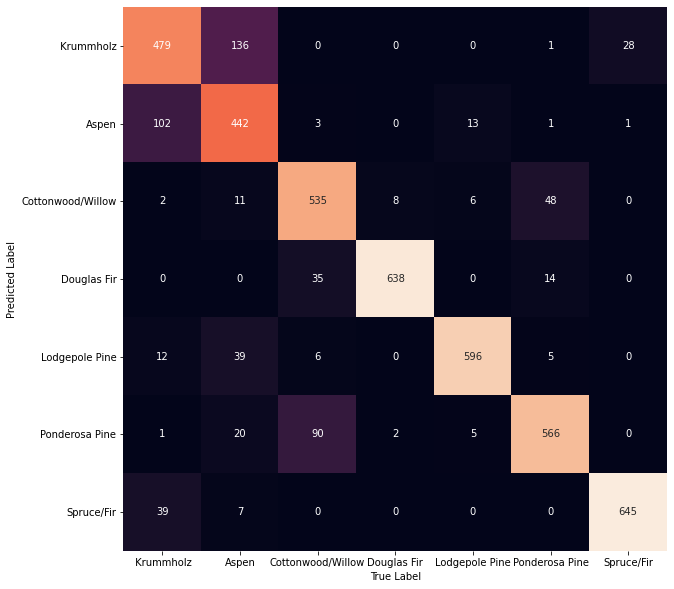

In [ ]:
RFClassifier = RandomForestClassifier(n_estimators=300, oob_score = True, max_depth = 50, bootstrap = True, random_state=17)    
report, y_predict , y_valid= ml_pipleline("Random Forest", RFClassifier, X_Orig, y, binarize = False, detailedCVcharts = False )
display_confusion_matrix (y_valid, y_predict)


#### With enhanced features 

Running with our engineered features and all orginal features from the dataset.


 Cross Validation Average Score 0.811
Confusion Matrix



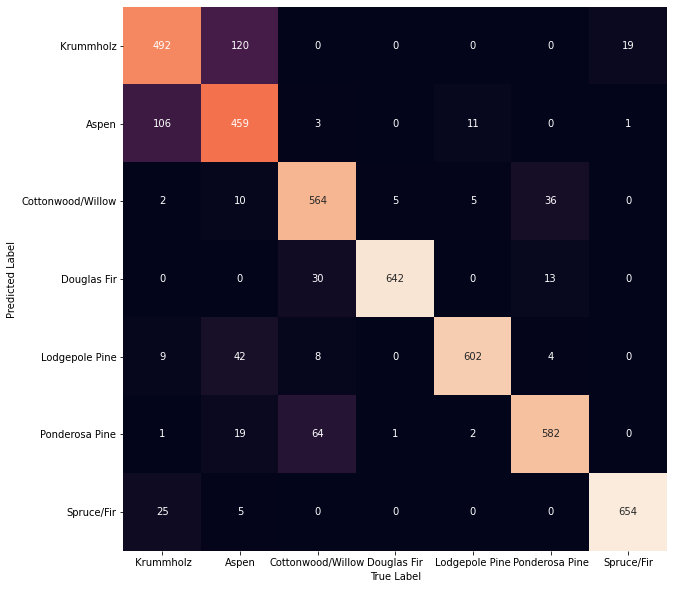

In [ ]:
RFClassifier = RandomForestClassifier(n_estimators=300, oob_score = True, max_depth = 50, bootstrap = True, random_state=17)    
report, y_predict , y_valid= ml_pipleline("Random Forest", RFClassifier, X_feature_engineered, y, binarize = False, detailedCVcharts = False )
display_confusion_matrix (y_valid, y_predict)

#### With enhanced features and simplification of our original features

Running the model with all engineered features, but the removal of sparse data columns from the orignal features. Specifically, we remove all the individual Soil Type columns since we have aggreagted that data with our engieered features.

In [ ]:
cover_feat_space,features_selected,X_std_train, X_std_valid, y_train, y_valid = feature_select_Data_for_Model(train_new)


 Cross Validation Average Score 0.872
Confusion Matrix



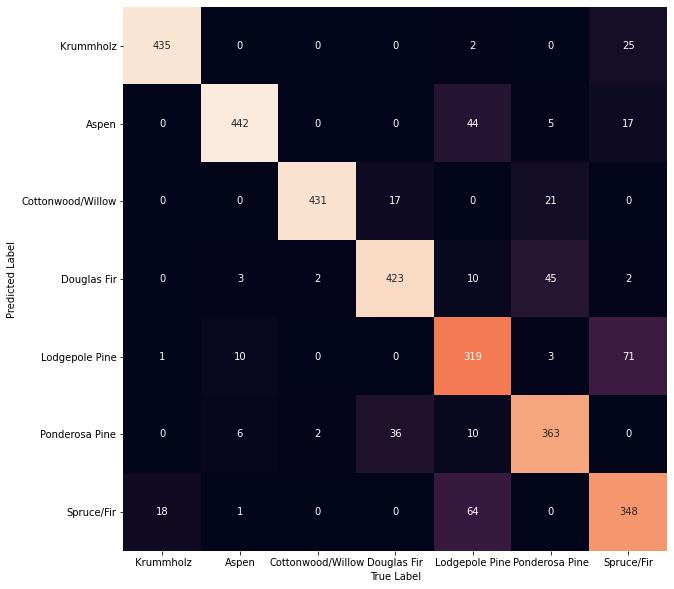

In [ ]:
#Soil type categorical
RFClassifier = RandomForestClassifier(n_estimators=300, oob_score = True, max_depth = 50, bootstrap = True, random_state=17)    
report, y_predict , y_valid= ml_pipleline("Random Forest", RFClassifier, X_std_train, y_train, \
                                          binarize = False, detailedCVcharts = False )
display_confusion_matrix (y_valid, y_predict)

The use of our enigeered features to provide more seperation between our soil variables, combined with the removal of sparse variables such as individual soil type columns, has signfigantly improved our model performance. 

## SVM

As with Random Forrest, SVM non-linear kernel Radial Bias Function (RBF) is tested on all three datasets. 

Implemented GridSearch to find the model with most optimized parameters. (GridSearch is commented out after identifying the best parameters to perserve the runtime of the notebook). 

In [ ]:
#svm_parameters = [{'kernel': ['rbf'], 'gamma': [0.00001, 0.001],'C': [1, 5, 10, 50]}] 
             
#clf = GridSearchCV(SVC(), svm_parameters, cv=5, verbose=2)
#clf.fit(X_train, y_train)    
#clf.best_params_
#means=clf.cv_results_['mean_test_score']
#stds=clf.cv_results_['std_test_score']

#print(clf.best_params_)
#print(means)
#print(stds)

The model which produced highest accuracy was then implemented subsequently

#### With our original data 


 Cross Validation Average Score 0.773
Confusion Matrix



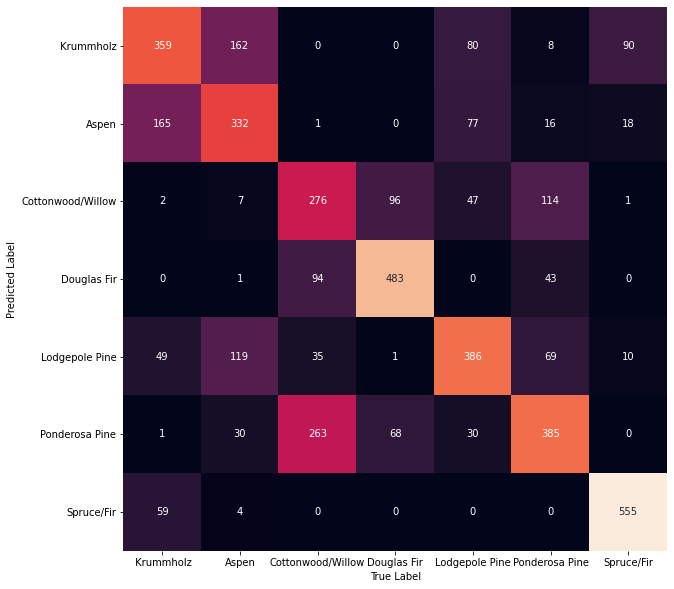

In [ ]:
SVMClassifier = SVC(kernel='rbf', gamma = 0.00001, C=10, random_state=17)    
report, y_predict , y_valid= ml_pipleline("SVM", SVMClassifier, X_Orig, y, binarize = False, detailedCVcharts = False )
display_confusion_matrix (y_valid, y_predict)

#### With our enhanced dataset

In [ ]:
SVMClassifier = SVC(kernel='rbf', gamma = 0.00001, C=10, random_state=17)    
report, y_predict , y_valid= ml_pipleline("SVM", SVMClassifier, X_feature_engineered, y, binarize = False, detailedCVcharts = False )
display_confusion_matrix (y_valid, y_predict)

#### With enhanced features and simplification of our original features

In [ ]:
cover_feat_space,features_selected,X_std_train, X_std_valid, y_train, y_valid = feature_select_Data_for_Model(train_new)

In [ ]:
SVMClassifier = SVC(kernel='rbf', gamma = 0.00001, C=10, random_state=17)    
report, y_predict , y_valid= ml_pipleline("SVM", SVMClassifier, X_std_train, y_train, binarize = False, detailedCVcharts = False )
display_confusion_matrix (y_valid, y_predict)

Unlike Random Forrest, SVM performs worse with the more features added. This is a result of SVM's use of vectors; for the best perfomance out of an SVM we would want the smallest number of numerical vectors with real representative values. By engieering many categorical vectors, the SVM is unable to find seperating planes as the demensions increase. 

## XGBoost

Similar to the Random Forrest, XGBoost was selected for its tree based method to hopefully improve the decision boundaries of the model when working with these overlapping features.

Additionally, XGBoost allows us to investigate feature importance as it pertains to the model which we take advantage of in this section.

Several XGBoost iterations led to optimizing hyperparameters. Below, we are showing the XGBoost model with parameters producing the highest accuracy

In [ ]:
def perform_xgb(X_train, y_train, X_valid, y_valid, predictors):
    import xgboost as xgb
    xgb0 = XGBClassifier(
        objective= 'multi:softprob',
         learning_rate =0.1,
         n_estimators=1000,
         max_depth=9,
         min_child_weight=1,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         nthread=4,
         scale_pos_weight=1,
         seed=27,
         eval_metric = ["merror", "map", "auc"],
         reg_alpha=0.005    
    )
    #     tree_method = "approx", 

    xgb0.fit(X_train, y_train,
             verbose=100,
    #          early_stopping_rounds=3,
             eval_metric=["auc", "mlogloss"]
            )

    y_train_predict = xgb0.predict(X_train)
    train_report = classification_report(y_train, y_train_predict)
    print('Training Set - Classication report metrics: \n ', train_report)

    y_predict = xgb0.predict(X_valid)
    report = classification_report(y_predict, y_valid)
    print('Validation Set - Classication report metrics: \n ', report)
    
    print(" ")
    cv_scores = cross_val_score(xgb0, X_train, y_train, cv=cross_validation)
    print('\n Cross Validation Average Score', round(np.mean(cv_scores),3))
    
    print('\n Confusion Matrix:')
    display_confusion_matrix (y_valid, y_predict)
    
    # plot
    plt.figure(figsize=(12,8))
    plt.bar(predictors,xgb0.feature_importances_ )
    plt.title("Feature Importance for XGBoost Prediction", size = 16)
    plt.xticks(predictors, predictors, rotation='vertical')
    plt.show()
    
    return(xgb0, y_predict)

#### With our original data 

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_Orig, y, test_size=0.3, random_state=17)

scaler = StandardScaler()
scalar = scaler.fit(X_train)
X_std_train = scaler.transform(X_train)
X_std_valid =  scaler.transform(X_valid)

In [ ]:
target = "Cover_Type"
predictors = [x for x in cover_feat_space.columns[0:54] if x not in [target]]
perform_xgb(X_std_train, y_train, X_std_valid, y_valid, predictors)

#### With our enhanced dataset

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_feature_engineered, y, test_size=0.3, random_state=17)

scaler = StandardScaler()
scalar = scaler.fit(X_train)
X_std_train = scaler.transform(X_train)
X_std_valid =  scaler.transform(X_valid)

In [ ]:
to_drop = ['Cover_Type']
cover_feat_space = train_new.drop(to_drop, axis = 1)
predictors = [x for x in cover_feat_space.columns if x not in [target]]
perform_xgb(X_std_train, y_train, X_std_valid, y_valid, predictors)

#### With enhanced features and collapsing soil type

In [ ]:
cover_feat_space,features_selected,X_std_train, X_std_valid, y_train, y_valid = feature_select_Data_for_Model(train_new)

In [ ]:
predictors = [x for x in cover_feat_space.columns if x not in [target]]
xgb_final, y_predict = perform_xgb(X_std_train, y_train, X_std_valid, y_valid, predictors)

The XGBoost model is our highest performing model thus far, but interesting this performance is maximized when we include all possible features in the model evaluation. This is also confirmed when looking at the feature importance for each model, where the inclusive set shows many more features of high improtance instead of only a few of very high importance in the other datasets.

## Neural networks

One of the last models thought to be of applicable use in this non-linear classification problem is a neural network for its ability to work with convoluted datasets. 

Several Neural Network iterations led to optimizing hyperparameters (number of hidden layers, number of nodes in each layer, activation function). Below, we are showing the Neural Network model with parameters producing the highest accuracy.

#### With our original data

In [ ]:
# train_df, col_names, X_Orig, y, y_labels, y_labels_display, y_binarized, cross_validation = get_Orig_Data_for_ML_Models()

In [ ]:
label_classes = [1,2,3,4,5,6,7]
y_binarized = label_binarize(y, classes=[1,2,3,4,5,6,7])


X_train, X_valid, y_train, y_valid = train_test_split(
    X_Orig, y_binarized, test_size=0.3, random_state=17)


scaler = StandardScaler()
scalar = scaler.fit(X_train)
X_std_train = scaler.transform(X_train)
X_std_valid =  scaler.transform(X_valid)

In [ ]:
model = Sequential()
model.add(Dense(units=200, input_dim=X_std_train.shape[1], activation='relu'))
model.add(Dense(units=100, input_dim=200, activation='relu'))
model.add(Dense(units=7, input_dim=50, activation='softmax'))
## Cost function & Objective (and solver)
model.compile(optimizer='adam', loss='CategoricalCrossentropy',metrics=['accuracy'])
history = model.fit(X_std_train, y_train, shuffle=True, batch_size=20,verbose=0, epochs=150)
score = model.evaluate(X_std_valid, y_valid, verbose=0)
print('Validation set accuracy:', round(score[1],3))
plt.plot(history.history['accuracy'])
plt.title("Epochs versus Accuracy")

#### With our enhanced dataset

In [ ]:
label_classes = [1,2,3,4,5,6,7]
y_binarized = label_binarize(y, classes=[1,2,3,4,5,6,7])


X_train, X_valid, y_train, y_valid = train_test_split(
    X_feature_engineered, y_binarized, test_size=0.3, random_state=17)


scaler = StandardScaler()
scalar = scaler.fit(X_train)
X_std_train = scaler.transform(X_train)
X_std_valid =  scaler.transform(X_valid)

In [ ]:
model = Sequential()
model.add(Dense(units=200, input_dim=X_std_train.shape[1], activation='relu'))
model.add(Dense(units=100, input_dim=200, activation='relu'))
model.add(Dense(units=7, input_dim=50, activation='softmax'))
## Cost function & Objective (and solver)
model.compile(optimizer='adam', loss='CategoricalCrossentropy',metrics=['accuracy'])
history = model.fit(X_std_train, y_train, shuffle=True, batch_size=20,verbose=0, epochs=150)
score = model.evaluate(X_std_valid, y_valid, verbose=0)
print('Validation set accuracy:', round(score[1],3))
plt.plot(history.history['accuracy'])
plt.title("Epochs versus Accuracy")

#### With enhanced features and collapsing soil type

In [ ]:
cover_feat_space,features_selected,X_std_train, X_std_valid, y_train, y_valid = feature_select_Data_for_Model(train_new, True)


In [ ]:
model = Sequential()
model.add(Dense(units=200, input_dim=X_std_train.shape[1], activation='relu'))
model.add(Dense(units=100, input_dim=200, activation='relu'))
model.add(Dense(units=7, input_dim=50, activation='softmax'))
## Cost function & Objective (and solver)
model.compile(optimizer='adam', loss='CategoricalCrossentropy',metrics=['accuracy'])
history = model.fit(X_std_train, y_train, shuffle=True, batch_size=20,verbose=0, epochs=150)
score = model.evaluate(X_std_valid, y_valid, verbose=0)
print('Validation set accuracy:', round(score[1],3))
plt.plot(history.history['accuracy'])
plt.title("Epochs versus Accuracy")

The neural network performs best with the Enhanced feature set with Simplification of Original features, this is likely because those orignal features were sparse and did not contribute much to activations of nodes when processed by the network.

### Best Model: Ensemble Model - Stacking

We sought to understand the effect of a meta-learning algorith, such as Stacking Ensemble Machine Learning, and see if we could improve our accuracy by combining well performing models. While this did not have an accuracy as high as other models such as Random Forest (see above), it did produce the highest accuracy on test data in Kaggle. 

#### Using our enhanced dataset, collapsing soil type

In [ ]:
cover_feat_space,features_selected,X_std_train, X_std_valid, y_train, y_valid = feature_select_Data_for_Model(train_new)

In [ ]:
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=1)),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth =100, bootstrap = True, random_state=17)),
    ('svm', SVC(kernel='rbf', gamma = 0.00001, C=10, random_state=17))
]

clf = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(
    objective= 'multi:softprob',
     learning_rate =0.2,
     n_estimators=1000,
     max_depth=9,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.6,
     nthread=4,
     scale_pos_weight=1,
     seed=27,
     eval_metric = ["merror", "map", "auc"],
     reg_alpha=0.005    
))

print(round(clf.fit(X_std_train, y_train).score(X_std_valid, y_valid),3))
print(" ")


cv_scores = cross_val_score(clf, X_std_train, y_train, cv=5)
print('\n Cross Validation Average Score', round(np.mean(cv_scores),3))

# APPENDIX - KAGGLE SUBMISSIONS

### Random Forest

In [ ]:
test_df = pd.read_csv('input/test.csv', index_col='Id')
test_df= add_soil_type(test_df)
test_df= add_soil_family(test_df)
test_df= add_Soil_Complex(test_df)
test_df= add_Soil_depth(test_df)
test_df= add_Soil_Stony(test_df)
test_df= add_Soil_Rubbly(test_df)
test_df= add_Soil_Bouldery(test_df)
test_df= add_Soil_Freezing(test_df)
test_df= add_Soil_Drainage(test_df)
test_df= add_Soil_Annual_Temp_Range(test_df)
test_df = add_light(test_df)
test_df = rename_wilderness_area(test_df)
test_df= add_more_features(test_df)
test_new = prepare_for_ML_Program(test_df, test=True)
# test_new.columns

# Feature 'Gothic' is not available in Train data
to_drop_test = ['Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8',
          'Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17',
          'Soil_Type18','Soil_Type19','Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26',
          'Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type26',
          'Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39', 'Soil_Type40', 'Gothic']

to_drop_train = ['Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8',
          'Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17',
          'Soil_Type18','Soil_Type19','Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26',
          'Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type26',
          'Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39', 'Soil_Type40', 'Cover_Type']

cover_feat_space_test = test_new.drop(to_drop_test, axis = 1)
cover_feat_space_train = train_new.drop(to_drop_train, axis = 1)

X_test = np.array(cover_feat_space_test).astype(np.float)
X = np.array(cover_feat_space_train).astype(np.float)


#Non-binarized
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

#Binarized
#X_train, X_valid, y_train, y_valid = train_test_split(X, y_binarized, test_size=0.3, random_state=17)

scaler = StandardScaler()
scalar = scaler.fit(X_train)
X_std_train = scaler.transform(X_train)
X_std_valid = scaler.transform(X_valid)
X_std_test = scaler.transform(X_test)

In [ ]:
RFClassifier = RandomForestClassifier(n_estimators=300, oob_score = True, max_depth = 50, bootstrap = True, random_state=17)    
print(RFClassifier.fit(X_std_train, y_train).score(X_std_valid, y_valid))
y_test_predict = RFClassifier.predict(X_std_test)

In [ ]:
X_ids = pd.DataFrame(test_df.index, columns =['Id'])
# Results
cover_types_dict = {1:'Spruce/Fir', 2:'Lodgepole Pine', 3:'Ponderosa Pine', 4:'Cottonwood/Willow', 5:'Aspen', 6:'Douglas Fir', 7:'Krummholz'}
y_test_labels = pd.DataFrame([cover_types_dict[value] for value in y_test_predict], columns =['cover_type'])
results = pd.concat([X_ids,y_test_labels], axis=1 )   

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Distribution of the Various Cover Types - Test Data", size = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax = sns.countplot(x = "cover_type", data = results)


In [ ]:
y_test_results = pd.DataFrame(y_test_predict,columns=['cover_type'])
final_results = pd.concat([X_ids,y_test_results], axis=1 )
final_results.to_csv('TestResultsRF.csv', index=False)

**Accuracy on Kaggle: 76%**

### XGBoost

In [ ]:
import xgboost as xgb
xgb0 = XGBClassifier(
    objective= 'multi:softprob',
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=9,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     nthread=4,
     scale_pos_weight=1,
     seed=27,
     eval_metric = ["merror", "map", "auc"],
     reg_alpha=0.005    
)
#     tree_method = "approx", 

xgb0.fit(X_train, y_train,
         verbose=100,
#          early_stopping_rounds=3,
         eval_metric=["auc", "mlogloss"]
        )

y_test_predict = xgb0.predict(X_std_test)

In [ ]:
X_ids = pd.DataFrame(test_df.index, columns =['Id'])
# Results
cover_types_dict = {1:'Spruce/Fir', 2:'Lodgepole Pine', 3:'Ponderosa Pine', 4:'Cottonwood/Willow', 5:'Aspen', 6:'Douglas Fir', 7:'Krummholz'}
y_test_labels = pd.DataFrame([cover_types_dict[value] for value in y_test_predict], columns =['cover_type'])
results = pd.concat([X_ids,y_test_labels], axis=1 )   

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Distribution of the Various Cover Types - Test Data", size = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax = sns.countplot(x = "cover_type", data = results)

In [ ]:
y_test_results = pd.DataFrame(y_test_predict,columns=['cover_type'])
final_results = pd.concat([X_ids,y_test_results], axis=1 )
final_results.to_csv('TestResultsXgb0.csv', index=False)

**Accuracy on Kaggle: 76.8%**

### Stacking Ensemble Model

In [ ]:
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=1)),
    ('rf', RandomForestClassifier(n_estimators=1000, max_depth =100, bootstrap = True, random_state=17)),
    ('svm', SVC(kernel='rbf', gamma = 0.00001, C=10, random_state=17))
]

clf = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(
    objective= 'multi:softprob',
     learning_rate =0.2,
     n_estimators=1000,
     max_depth=9,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.6,
     nthread=4,
     scale_pos_weight=1,
     seed=27,
     eval_metric = ["merror", "map", "auc"],
     reg_alpha=0.005    
))

print(round(clf.fit(X_std_train, y_train).score(X_std_valid, y_valid),3))
print(" ")
y_test_clf_predict = clf.predict(X_std_test)

In [ ]:
X_ids = pd.DataFrame(test_df.index, columns =['Id'])
# Results
cover_types_dict = {1:'Spruce/Fir', 2:'Lodgepole Pine', 3:'Ponderosa Pine', 4:'Cottonwood/Willow', 5:'Aspen', 6:'Douglas Fir', 7:'Krummholz'}
y_test_labels = pd.DataFrame([cover_types_dict[value] for value in y_test_clf_predict], columns =['cover_type'])
results = pd.concat([X_ids,y_test_labels], axis=1 )   

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Distribution of the Various Cover Types - Test Data", size = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax = sns.countplot(x = "cover_type", data = results)

In [ ]:
y_test_results = pd.DataFrame(y_test_clf_predict,columns=['cover_type'])
final_results = pd.concat([X_ids,y_test_results], axis=1 )
final_results.to_csv('TestResultsClf.csv', index=False)

**Accuracy on Kaggle: 77.7%**

### Neural Network Model

In [ ]:
label_classes = [1,2,3,4,5,6,7]
y_binarized = label_binarize(y, classes=[1,2,3,4,5,6,7])

# Dropping output from feature space
# to_drop = ['Cover_Type']
to_drop = ['Cover_Type','Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8',
          'Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17',
          'Soil_Type18','Soil_Type19','Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26',
          'Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type26',
          'Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39', 'Soil_Type40']



cover_feat_space_train = train_new.drop(to_drop, axis = 1)

# Pull out geatures for future use
features_selected = cover_feat_space_train.columns
X = np.array(cover_feat_space_train).astype(np.float)


X_train, X_valid, y_train, y_valid = train_test_split(
        X, y_binarized, test_size=0.3, random_state=17)

scaler = StandardScaler()
scalar = scaler.fit(X_train)
X_std_train = scaler.transform(X_train)
X_std_valid =  scaler.transform(X_valid)   

In [ ]:
model = Sequential()
model.add(Dense(units=200, input_dim=X_std_train.shape[1], activation='relu'))
model.add(Dense(units=100, input_dim=200, activation='relu'))
model.add(Dense(units=7, input_dim=50, activation='softmax'))
## Cost function & Objective (and solver)
model.compile(optimizer='adam', loss='CategoricalCrossentropy',metrics=['accuracy'])
history = model.fit(X_std_train, y_train, shuffle=True, batch_size=20,verbose=0, epochs=150)
score = model.evaluate(X_std_valid, y_valid, verbose=0)
print('Validation set accuracy:', round(score[1],3))
plt.plot(history.history['accuracy'])
plt.title("Epochs versus Accuracy")

In [ ]:
test_df = pd.read_csv('input/test.csv', index_col='Id')
test_df= add_soil_type(test_df)
test_df= add_soil_family(test_df)
test_df= add_Soil_Complex(test_df)
test_df= add_Soil_depth(test_df)
test_df= add_Soil_Stony(test_df)
test_df= add_Soil_Rubbly(test_df)
test_df= add_Soil_Bouldery(test_df)
test_df= add_Soil_Freezing(test_df)
test_df= add_Soil_Drainage(test_df)
test_df= add_Soil_Annual_Temp_Range(test_df)
test_df = add_light(test_df)
test_df = rename_wilderness_area(test_df)
test_df= add_more_features(test_df)
test_new = prepare_for_ML_Program(test_df, test=True)

# Feature 'Gothic' is not available in Train data
to_drop_test = ['Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8',
          'Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17',
          'Soil_Type18','Soil_Type19','Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26',
          'Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type26',
          'Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39', 'Soil_Type40', 'Gothic']

cover_feat_space_test = test_new.drop(to_drop_test, axis = 1)

X_test = np.array(cover_feat_space_test).astype(np.float)
X_std_test =  scaler.transform(X_test) 

In [ ]:
y_test_predict = model.predict(X_std_test)
classes_predict = np.argmax(y_test_predict, axis = 1)
y_test_predict_nn = [x+1 for x in classes_predict]

In [ ]:
X_ids = pd.DataFrame(test_df.index, columns =['Id'])
# Results
cover_types_dict = {1:'Spruce/Fir', 2:'Lodgepole Pine', 3:'Ponderosa Pine', 4:'Cottonwood/Willow', 5:'Aspen', 6:'Douglas Fir', 7:'Krummholz'}
y_test_labels = pd.DataFrame([cover_types_dict[value] for value in y_test_predict_nn], columns =['cover_type'])
results = pd.concat([X_ids,y_test_labels], axis=1 )   

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Distribution of the Various Cover Types - Test Data", size = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax = sns.countplot(x = "cover_type", data = results)

In [ ]:
y_test_results = pd.DataFrame(y_test_predict_nn,columns=['cover_type'])
final_results = pd.concat([X_ids,y_test_results], axis=1 )
final_results.to_csv('TestResultsNN.csv', index=False)

**Accuracy on Kaggle: 72.8%**

### SVM

In [ ]:
# Isolate target data
cover_type = train_df['Cover_Type']
y = np.array(cover_type)

# Dropping output from feature space
to_drop = ['Cover_Type']
cover_feat_space = train_df.drop(to_drop, axis = 1)

# Pull out geatures for future use
features = cover_feat_space.columns
X = np.array(cover_feat_space).astype(np.float)

print("Feature space hold %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

In [ ]:

def add_feature(data):   
    data['Distance_to_Hydrology'] = (data['Horizontal_Distance_To_Hydrology']**2+data['Vertical_Distance_To_Hydrology']**2)**0.5
    return data

train_df = add_feature(train_df)
test_df = add_feature(test_df)


In [ ]:
train_df['Soil_Type'] = (train_df.iloc[:,15:55] == 1).idxmax(1)
test_df['Soil_Type'] = (test_df.iloc[:,15:55] == 1).idxmax(1)

In [ ]:
train_df['Wilderness_Areas'] = (train_df.iloc[:,10:14] == 1).idxmax(1)
test_df['Wilderness_Areas'] = (test_df.iloc[:,10:14] == 1).idxmax(1)

In [ ]:
to_drop=['Cover_Type']
train_df = train_df.drop(to_drop, axis = 1)

In [ ]:
np.random.seed(0)


X_train,X_test,y_train,y_test = train_test_split(train_df, y, test_size=0.2, random_state=123)
svm_parameters = [{'kernel': ['rbf'], 'gamma': [0.00001],'C': [10]}] 

#svm_parameters = [{'kernel': ['rbf'], 'C': [1,10,100]}]                
clf = GridSearchCV(SVC(), svm_parameters, cv=3, verbose=2)
clf.fit(train_df, y)    
clf.best_params_
means=clf.cv_results_['mean_test_score']
stds=clf.cv_results_['std_test_score']

print(clf.best_params_)
print(means)
print(stds)

In [ ]:
model=clf.best_estimator_
#yfit=model.predict(X_test)

In [ ]:
y_labels=train_df['Cover_Type']
y_labels.replace({1:'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas Fir', 7: ' Krummholz'}, inplace=True)

In [ ]:

from sklearn.metrics import classification_report
print(classification_report(y_test, yfit, target_names=np.unique(y_labels)))

In [ ]:
mat = confusion_matrix(y_test, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y_labels),
            yticklabels=np.unique(y_labels))
plt.xlabel('True Label')
plt.ylabel('Predicted Label')


plt.show()

In [ ]:
to_drop=['Gothic']
test_df=test_df.drop(to_drop, axis = 1)

In [ ]:
y_test_predict=model.predict(test_df)
X_ids = pd.DataFrame(test_df.index, columns =['Id'])

y_test_results = pd.DataFrame(y_test_predict,columns=['cover_type'])
final_results = pd.concat([X_ids,y_test_results], axis=1 )
final_results.to_csv('TestResults2.csv')


**Accuracy on Kaggle: 72.5%**